# Lagrangian rotary spectra following eddy centers

In [1]:
import h5py
import numpy as np
from scipy import signal
from EddyTracks import EddyTracks, DifferentiateEddies, fillCoords
from matplotlib import pyplot as plt

In [2]:
fpaths = ['/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik1_Rb_0p8_Rmin_2dx/',
          '/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik58_Rb_0p8_Rmin_2dx/',
          '/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik89_Rb_0p8_Rmin_2dx/']
depths = ['Surface', '500m', '1500m']
tracks_full = {depth:[] for depth in depths}  # dictionary for tracks at each depth

for i,fpath in enumerate(fpaths):
    tracks = EddyTracks(fpath)
    print(depths[i]+':', len(tracks), 'eddies')
    tracks_full[depths[i]] = tracks

Surface: 738 eddies
500m: 216 eddies
1500m: 216 eddies


In [3]:
lifetime = 0                                   # lifetime filter (in hours)
cyclones = {depth:[] for depth in depths}      # dictionary of cyclonic eddies at each depth
anticyclones = {depth:[] for depth in depths}  # dictionary of anticyclonic eddies at each depth

for depth in depths:
    # separate eddies by rotation
    tracks = tracks_full[depth]
    cyclones[depth], anticyclones[depth] = DifferentiateEddies(tracks)

print('Num Eddies')
for depth in depths:
    print(f'{depth:9}a: {len(anticyclones[depth])}  c: {len(cyclones[depth])}')

Num Eddies
Surface  a: 313  c: 425
500m     a: 115  c: 101
1500m    a: 104  c: 112


In [4]:
from scipy.io import netcdf
grids = ['GLazur64-T20_y2009m0607_gridU_ik1.nc',
        'GLazur64-T20_y2009m0607_gridV_ik1.nc',
        'GLazur64-T20_y2009m0607_gridU_ik58.nc',
        'GLazur64-T20_y2009m0607_gridV_ik58.nc',
        'GLazur64-T20_y2009m0607_gridU_ik89.nc',
        'GLazur64-T20_y2009m0607_gridV_ik89.nc']

gridU = {depth:[] for depth in depths}  # initialize zonal velocities at each depth
gridV = {depth:[] for depth in depths}  # initialize meridional velocities at each depth
j = 0
for i,depth in enumerate(depths):
    # add velocity data to the corresponding depth
    gridU[depth] = netcdf.netcdf_file(fpaths[i] + grids[j],'r')
    gridV[depth] = netcdf.netcdf_file(fpaths[i] + grids[j+1],'r')
    j += 2

lowest_lon = gridU['Surface'].variables['nav_lon'][0, 0].copy()  # lowest longitude
lowest_lat = gridU['Surface'].variables['nav_lat'][0, 0].copy()  # lowest latitude
nav_res = 1./64                                                  # spatial resolution (in degrees)
dt = 1.0                                                         # temporal resolution (in hours)
omega = 7.2921e-5
print('lowest_lon:', lowest_lon)
print('lowest_lat:', lowest_lat)

lowest_lon: 2.1015625
lowest_lat: 41.2624


In [5]:
eddyTypes = ['cyclone', 'anticyclone']             # eddy types
plotVars = ['amps', 'freqs']                       # plot variables
spectra = {eddyType:[] for eddyType in eddyTypes}  # spectra for each eddy type

# loop through cyclones and anticyclones
for eddyType in eddyTypes:
    spectra[eddyType] = {depth:[] for depth in depths}  # spectra for each depth
    for depth in depths:
        spectra[eddyType][depth] = {plotVar:[] for plotVar in plotVars}  # plot variables for each depth
        
        if eddyType == 'cyclone':
            tracks = cyclones[depth]
        else:
            tracks = anticyclones[depth]
        
        n = len(tracks[0]['step'])  # fixed num values for fft
        for track in tracks:
            steps = len(track['step'])
            if steps > n:
                n = steps
        
        fullTimes = np.arange(0, n, dt)
        fq = np.fft.fftfreq(fullTimes.shape[-1],dt)  # frequencies corresponding to each FC
        
        for track in tracks:
            steps, lons, lats = fillCoords(track['step'], track['x1'], track['y1'], fill='linear')
            maxt = len(steps)  # num steps this eddy is present

            fCor = 2.*omega*np.sin((lats[len(lats)//2])/180*np.pi)  # coriolis frequency (rad/sec)

            # Tapered cosine window
            alpha = 0.2
            win = signal.tukey(maxt, alpha)  # 20% of points

            hvels = []
            for i in range(len(steps)):
                # interpolate U and V at each eddy center
                target_lon = lons[i]  # longitude of eddy center
                target_lat = lats[i]  # latitude of eddy center
                
                lb_lon = int((target_lon - lowest_lon)/nav_res)  # index of lon lower bound
                lb_lat = int((target_lat - lowest_lat)/nav_res)  # index of lat lower bound

                W2lon = (target_lon - lowest_lon)%nav_res  # W2 lon
                W2lat = (target_lat - lowest_lat)%nav_res  # W2 lat

                Us = gridU[depth].variables['vozocrtx'][i, 0, lb_lat:lb_lat+2, lb_lon:lb_lon+2].copy()  # zonal velocities
                Vs = gridV[depth].variables['vomecrty'][i, 0, lb_lat:lb_lat+2, lb_lon:lb_lon+2].copy()  # meridional velocities

                # interpolate for U and V (based on unit square)
                U_target = Us[0,0]*(1-W2lon)*(1-W2lat) + Us[0,1]*W2lon*(1-W2lat) + Us[1,0]*(1-W2lon)*W2lat + Us[1,1]*W2lon*W2lat
                V_target = Vs[0,0]*(1-W2lon)*(1-W2lat) + Vs[0,1]*W2lon*(1-W2lat) + Vs[1,0]*(1-W2lon)*W2lat + Vs[1,1]*W2lon*W2lat

                hvels.append(U_target + 1j*V_target)

            fcs = np.fft.fft(hvels*win, n=n)  # k58 Fourier coefficients (FCs) w/ window and padded to n
            amp = np.abs(fcs)**2
            fq_norm = fq*2*np.pi/fCor/3600
            if track is tracks[0]:
                amps = amp           # initialize array for amplitudes
                fq_norms = fq_norm   # initialize array for normalized frequencies
            else:
                amps += amp          # add to amplitudes
                fq_norms += fq_norm  # add to normalized frequencies
        
        nTracks = len(tracks)   # number of tracks
        amps /= nTracks         # average amplitudes
        fq_norms /= nTracks     # average frequencies
        
        # shift for plotting
        spectra[eddyType][depth]['amps'] = np.fft.fftshift(amps)       
        spectra[eddyType][depth]['freqs'] = np.fft.fftshift(fq_norms)

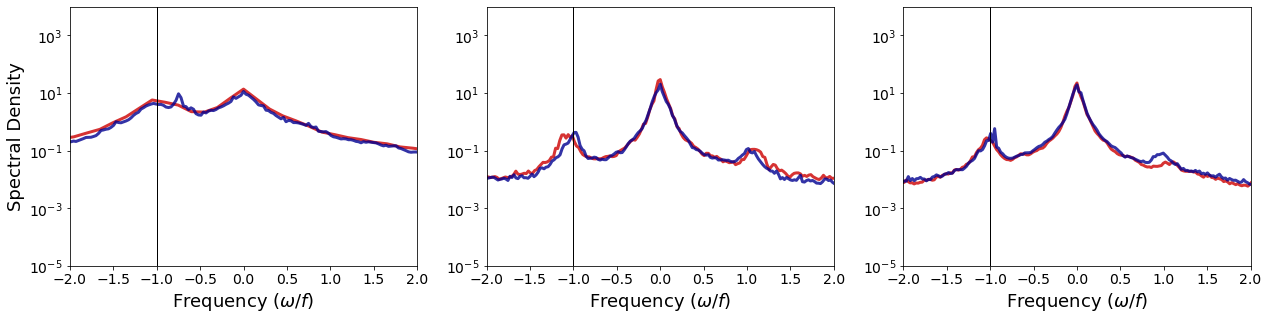

In [6]:
fig = plt.figure(figsize=(21.16,4.77))
red = (1-0.2, 0,0)       # red used in presentation
blue = (0, 0, 1-0.4353)  # blue used in presentation
i=1
for depth in depths:
    ax = fig.add_subplot(1,3,i)
    ax.plot(spectra['cyclone'][depth]['freqs'], spectra['cyclone'][depth]['amps'],
            color=red, label='cyclones', linewidth=3, alpha=0.8)
    ax.plot(spectra['anticyclone'][depth]['freqs'], spectra['anticyclone'][depth]['amps'],
            color=blue, label='anticyclones', linewidth=3, alpha=0.8)
    
    # Set the font name for axis tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    
    ax.set_yscale('log')
    ax.set_xlim(-2,2)
    ax.set_ylim(1e-5,1e4)
    plt.axvline(x=-1, color='k', linewidth=1)
    ax.set_xlabel('Frequency ($\omega$/$\it{f}$)', fontsize=18)
    #ax.set_title(depth, fontsize=20)
    #plt.legend()
    if i<2:
        ax.set_ylabel('Spectral Density', fontsize=18)
    i+=1

plt.show()
fig_path = './figures/'
fname = 'spectra_eddies.png'
fig.tight_layout()
fig.savefig(fig_path+fname, dpi=80)